### Load required packages and libraries

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

import seaborn as sns

### Import and inspect the data:

In [2]:
# load the data
data = pd.read_csv('Medical_Npatients50000.csv')

We use a medical dataset. Our job is to make predictions about whether a patient is ill or not using the information provided.

In [3]:
# check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0     Age          50000 non-null  float64
 1        Qsmoke    50000 non-null  float64
 2      Qpolitic    50000 non-null  float64
 3    Qsocial       50000 non-null  float64
 4     BMI          50000 non-null  float64
 5        Roccupat  50000 non-null  float64
 6    Rgenetic      50000 non-null  float64
 7    Rdietary      50000 non-null  float64
 8    Rhormonn      50000 non-null  float64
 9    DocScore      50000 non-null  float64
 10    TrulyIll     50000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 4.2 MB


In [4]:
# data description
data.describe()

,Age,Qsmoke,Qpolitic,Qsocial,BMI,Roccupat,Rgenetic,Rdietary,Rhormonn,DocScore,TrulyIll
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,56.165045,0.500210,0.499261,0.501386,24.559206,0.06201,0.359978,0.109239,0.084732,0.395208,0.230120
std,10.297933,0.269642,0.288475,0.197588,7.817936,0.05314,0.139365,0.135008,0.105914,0.315242,0.420914
min,0.000000,-0.019000,0.000000,-0.027000,-30.000000,0.00000,0.000000,-0.020000,0.050000,0.029400,0.000000
25%,51.130000,0.263000,0.250000,0.368000,18.350000,0.02800,0.262000,0.026000,0.050000,0.144100,0.000000
50%,57.190000,0.501000,0.500000,0.501000,23.750000,0.04600,0.349000,0.062000,0.050000,0.265600,0.000000
75%,61.940000,0.737000,0.750000,0.630000,30.200000,0.07800,0.442000,0.137000,0.050000,0.611500,0.000000
max,110.000000,1.093000,1.000000,0.987000,47.810000,0.71600,1.098000,2.970000,1.448000,0.999900,1.000000


In [5]:
print(data.columns)

Index(['  Age', '     Qsmoke', '   Qpolitic', ' Qsocial', '  BMI',
       '     Roccupat', ' Rgenetic', ' Rdietary', ' Rhormonn', ' DocScore',
       '  TrulyIll'],
      dtype='object')


Data columns have spaces in the headers, we remove them using `.strip()` below

In [6]:
data.columns = data.columns.str.strip()

In [7]:
print(data.columns)

Index(['Age', 'Qsmoke', 'Qpolitic', 'Qsocial', 'BMI', 'Roccupat', 'Rgenetic',
       'Rdietary', 'Rhormonn', 'DocScore', 'TrulyIll'],
      dtype='object')


__Check data relationship__

In [8]:
# let's first remove the truth labels
df = data.drop('TrulyIll',axis=1)

In [9]:
# first, let's compute the correlation of the data columns using pandas corr() method
df_corr = df.corr()

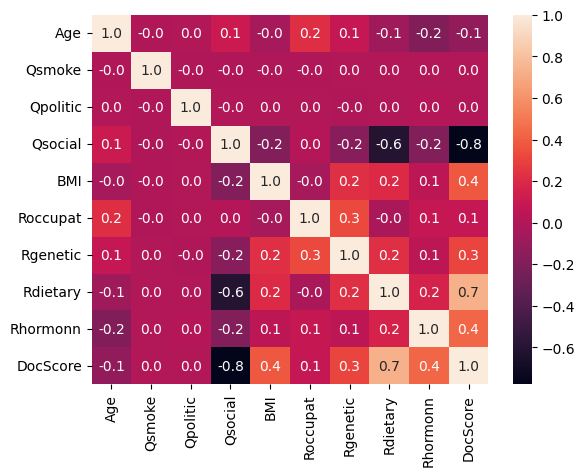

In [10]:
# use seaborn's heatmap to visualize the correlation
fig, ax = plt.subplots()

ax = sns.heatmap(df_corr,annot=True,fmt='.1f')

Correlation between data is generally low except for `Rdietary` and `DocScore` which have correlation > 0.5. We use all data columns and proceed.

### XGBoost

We use XGBoost for to train our model and then make predictions about the Ill or not Ill classifications.

In [11]:
# df does not contain the truth labels, the original dataframe named `data` does
X = df
y = data['TrulyIll']

In [12]:
X.head()

,Age,Qsmoke,Qpolitic,Qsocial,BMI,Roccupat,Rgenetic,Rdietary,Rhormonn,DocScore
0,60.19,0.019,0.385,0.577,38.16,0.051,0.563,0.027,0.05,0.2610
1,48.61,0.927,0.880,0.847,18.10,0.268,0.587,0.031,0.05,0.2082
2,64.44,0.363,0.917,0.505,24.86,0.121,0.342,0.037,0.05,0.2575
3,37.94,0.654,0.414,0.838,15.23,0.028,0.426,0.015,0.05,0.0614
4,58.92,0.078,0.870,0.523,27.25,0.052,0.218,0.024,0.05,0.2973


In [13]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: TrulyIll, dtype: int64

In [14]:
# split the training and test data at 80-20 %
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42)

We use XGBClassifier.
Here we use a minimal example. Hyperparameters have not been optimized.

In [15]:
# Initialize and train the model

# barely any hyperparameters are defined here. For optimal performance, these must be tuned.
xgb_clf = XGBClassifier(max_depth=6,objective='binary:logistic')

# Train the model
xgb_clf.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of predictions: 0.905


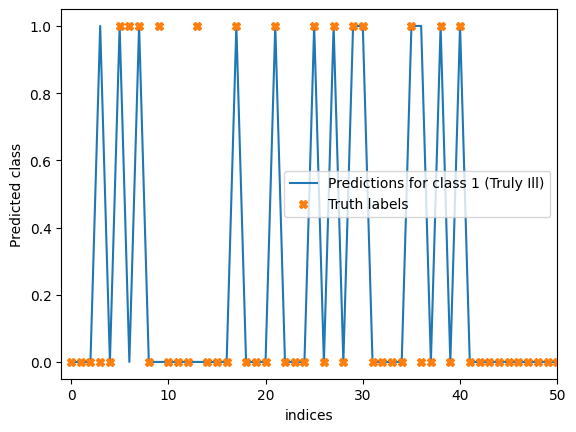

In [16]:
# Make predictions and compute the accuracy on the test set
y_pred = xgb_clf.predict(X_test)
print(f'Accuracy of predictions: {accuracy_score(y_test,y_pred):.3f}')

# probabilities for one class
y_prob = xgb_clf.predict_proba(X_test)[:,1]


# visual comparison
idx = np.linspace(0,10000,10000)
plt.plot(idx,y_pred,label='Predictions for class 1 (Truly Ill)')
plt.plot(idx,y_test,'X',label='Truth labels')
plt.ylabel('Predicted class')
plt.xlabel('indices')
plt.xlim(-1,50)
plt.legend()
plt.show()

We see above that there are many inaccuracies in our predictions.

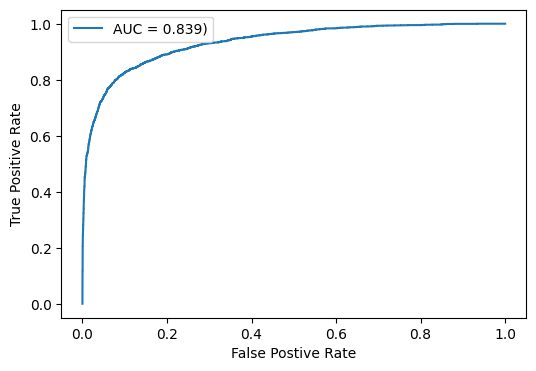

In [17]:
# ROC curve
# these are the false and true positive rates for the model
fpr, tpr, _ = roc_curve(y_test, y_prob)             

# We can now calculate the Area-Under-the-Curve (AUC) scores of these ROC-curves:
auc_score = roc_auc_score(y_test,y_pred)                      

# plot
fig = plt.figure(figsize = [6,4])
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f})')
plt.legend(fontsize=10)
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### With some hyperparameter optimization

We look for the best set of parameters using `GridSearchCV`.

In [18]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()

# optmize the hyperparameters
optimization_dict = {'objective': ['binary:logistic','reg:squarederror','binary:hinge'],
                     'max_leaves':np.arange(2,5,1),
                     'max_depth': np.arange(2,5,1),
                     'n_estimators': [110,120,130]}

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1)

# train the model
model.fit(X_train,y_train)

# get the best parameters
best_params = model.best_params_

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0.9048
{'max_depth': np.int64(2), 'max_leaves': np.int64(4), 'n_estimators': 130, 'objective': 'binary:logistic'}


Let's use these `best parameters`.

In [19]:
# define the model
model = xgb.XGBClassifier(**best_params)

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.906


We still couldn't improve the accuracy by much here, this might require more deeper dive into the problem if accuracy must be higher for a solution to a problem. 
For now, let's move on and look at how important were the features in the dataset while making predictions using the model.

### Feature importances

In [20]:
# Get feature importances and the labels
importances = model.get_booster().get_score(importance_type='gain')

# we get a dictionary of feature importances. Convert that to a dataframe for plotting purposes
importance_df = pd.DataFrame(
    list(importances.items()), 
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# check
importance_df.head()

,Feature,Importance
9,DocScore,734.431152
0,Age,32.809196
7,Rdietary,25.679348
3,Qsocial,14.521475
1,Qsmoke,13.562350


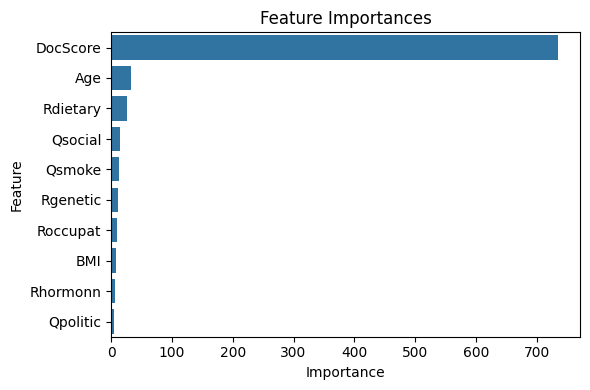

In [21]:
# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


There are other metrics to inspect the feature importances for a model. One of them is called SHAP values. We use a `violin` plot below. More info on that can be found here: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html 

In [22]:
import shap

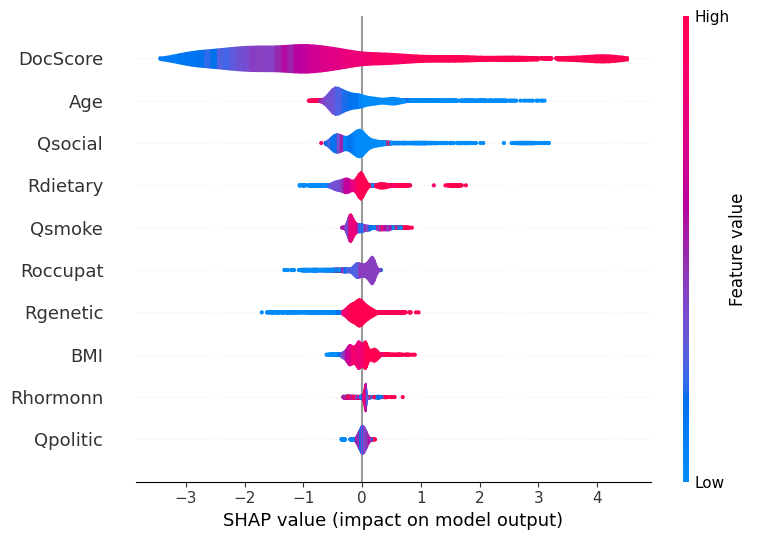

<Figure size 640x480 with 0 Axes>

In [23]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# violin plot
plt.figure(figsize=(6,4))
shap.summary_plot(shap_values, X_test,plot_type='violin')
plt.tight_layout()
plt.show()

From the feature importance plot and the SHAP value plots, we see that `DocScore` is by far the most important variable in determining whether someone is ill or not.

The SHAP values also provide further information. For example, lower `Age` value (blue color) indicates that you are more likely to be TrulyIll.